In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.cosmology import FlatLambdaCDM 
from astropy.table import Table
import astropy.units as u

In [2]:
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

In [3]:
objects = [
    "W0019-1046",
    "W0204-0506",
    "W0220+0137",
    "W0831+0140",
]

In [4]:
#Find the redshift of each object. 
z = dict()
d20 = open("../SED_models/double.20")
d22 = open("../SED_models/double.22")
for line in d20:
    x = line.split()
    y = d22.readline().split()
    z[y[-1]] = float(x[1])
d20.close()
d22.close()

In [5]:
#Load the seeing values. 
seeing = Table.read("../../Resolved_Polarization_v3/All_seeing_values.txt", format='ascii')
seeing.rename_column("col1", "WID")
seeing.rename_column("col2", "FWHM")
seeing.rename_column("col3", "filename")

In [6]:
#Set the angle and pfrac limits for each object. 
plot_lims = dict()
plot_lims['W0019-1046'] = {'pfrac':{'min': 3.,'max':10.},'pangle':{'min':0,'max':180}}
plot_lims['W0204-0506'] = {'pfrac':{'min':20.,'max':35.},'pangle':{'min':0,'max':180}}
plot_lims['W0220+0137'] = {'pfrac':{'min':10.,'max':20.},'pangle':{'min':0,'max':180}}
plot_lims['W0831+0140'] = {'pfrac':{'min': 5.,'max':15.},'pangle':{'min':0,'max':180}}

In [7]:
def make_plot(blurr_PSF_FWHM=None, snr_stack_lim=5.0, size=20, band="R_SPECIAL", output_fname=None):

    #folder = "../../Resolved_Polarization_v3/stamps_blurred_1.0"
    #blurr_PSF_FWHM = 1.0
    if blurr_PSF_FWHM is None:
        folder = "../../Resolved_Polarization_v3/stamps"
    else:
        folder = "../../Resolved_Polarization_v3/stamps_blurred_{:.1f}".format(blurr_PSF_FWHM)

    #Load the pol images. 
    ims = dict()
    for obj in objects:
        ims[obj] = dict()
        for imtype in ["pfrac","pangle","stack"]:
            ims[obj][imtype] = fits.open("{}/{}.{}.All.{}.fits".format(folder,obj,band,imtype))
            if imtype=='pfrac':
                ims[obj][imtype][0].data *= 100

    #Mask based on the stack image. 
    for obj in objects:
        _, _, rms = sigma_clipped_stats(ims[obj]['stack'][0].data, sigma=3.0)
        pmask = np.where(ims[obj]['stack'][0].data<snr_stack_lim*rms, True, False)
        ims[obj]['pfrac'][0].data[pmask] = np.nan
        ims[obj]['pangle'][0].data[pmask] = np.nan

    #Make the plot  
    pixscale = 0.126*2

    fig, axs = plt.subplots(2, len(objects), figsize=(40,18), sharex=True, sharey=True, squeeze=False)
    plt.subplots_adjust(wspace=0., hspace=0.)
    for ax in axs.flat:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])

    ix1 = int(ims[objects[0]]['pfrac'][0].data.shape[1]/2 - size/2)
    ix2 = int(ims[objects[0]]['pfrac'][0].data.shape[1]/2 + size/2 * 1.3)
    iy1 = int(ims[objects[0]]['pfrac'][0].data.shape[0]/2 + size/2)
    iy2 = int(ims[objects[0]]['pfrac'][0].data.shape[0]/2 - size/2)

    cmaps = {'pfrac':'plasma_r', 'pangle':'hsv'}

    for i, obj in enumerate(objects):
        for k, imtype in enumerate(['pfrac','pangle']):
            cm = axs[k,i].imshow(ims[obj][imtype][0].data[iy1:iy2:-1,ix1:ix2], vmin=plot_lims[obj][imtype]['min'], vmax=plot_lims[obj][imtype]['max'], cmap=cmaps[imtype])

            cax = inset_axes(axs[k,i], width="5%", height="90%", loc='right') 
            cbar = fig.colorbar(cm, cax=cax, orientation='vertical')
            cbar.ax.tick_params(labelsize=20)
            if imtype=='pfrac':
                cbar.set_label(label=r'$P (\%)$', fontsize=28, weight='bold')
            else:
                cbar.set_label(label=r'$\chi (\rm deg)$', fontsize=28, weight='bold')
            cax.yaxis.set_ticks_position('left')
            cax.yaxis.set_label_position('left')

        #Object label
        axs[0,i].text(0.05, 0.9, obj, transform=axs[0,i].transAxes, fontsize=40, weight='bold')

        #Beam size
        beam_FWHM = np.max(seeing['FWHM'][seeing['WID']==obj])
        if blurr_PSF_FWHM is not None:
            beam_FWHM = (beam_FWHM**2 + blurr_PSF_FWHM**2)**0.5
        for k in [0,1]:
            beam  = plt.Circle((size*0.15,size*0.8),beam_FWHM/2/pixscale, color='k', fill=False)
            axs[k,i].add_patch(beam)

        #10kpc bar
        bar_size = (10*u.kpc/cosmo.angular_diameter_distance(z[obj]))*u.rad
        bar_size_pix = bar_size.to(u.arcsec).value / pixscale
        for k in [0,1]:
            axs[k,i].errorbar([size*0.75],[size*0.9],xerr=[bar_size_pix/2.], fmt='none', capsize=10.0)
            axs[k,i].text(size*0.75,size*0.9,"10 kpc",ha='center',va='bottom', fontsize=26)

    #fig.tight_layout()
    plt.show()
    if output_fname is not None:
        fig.savefig(output_fname, dpi=200)
    return 

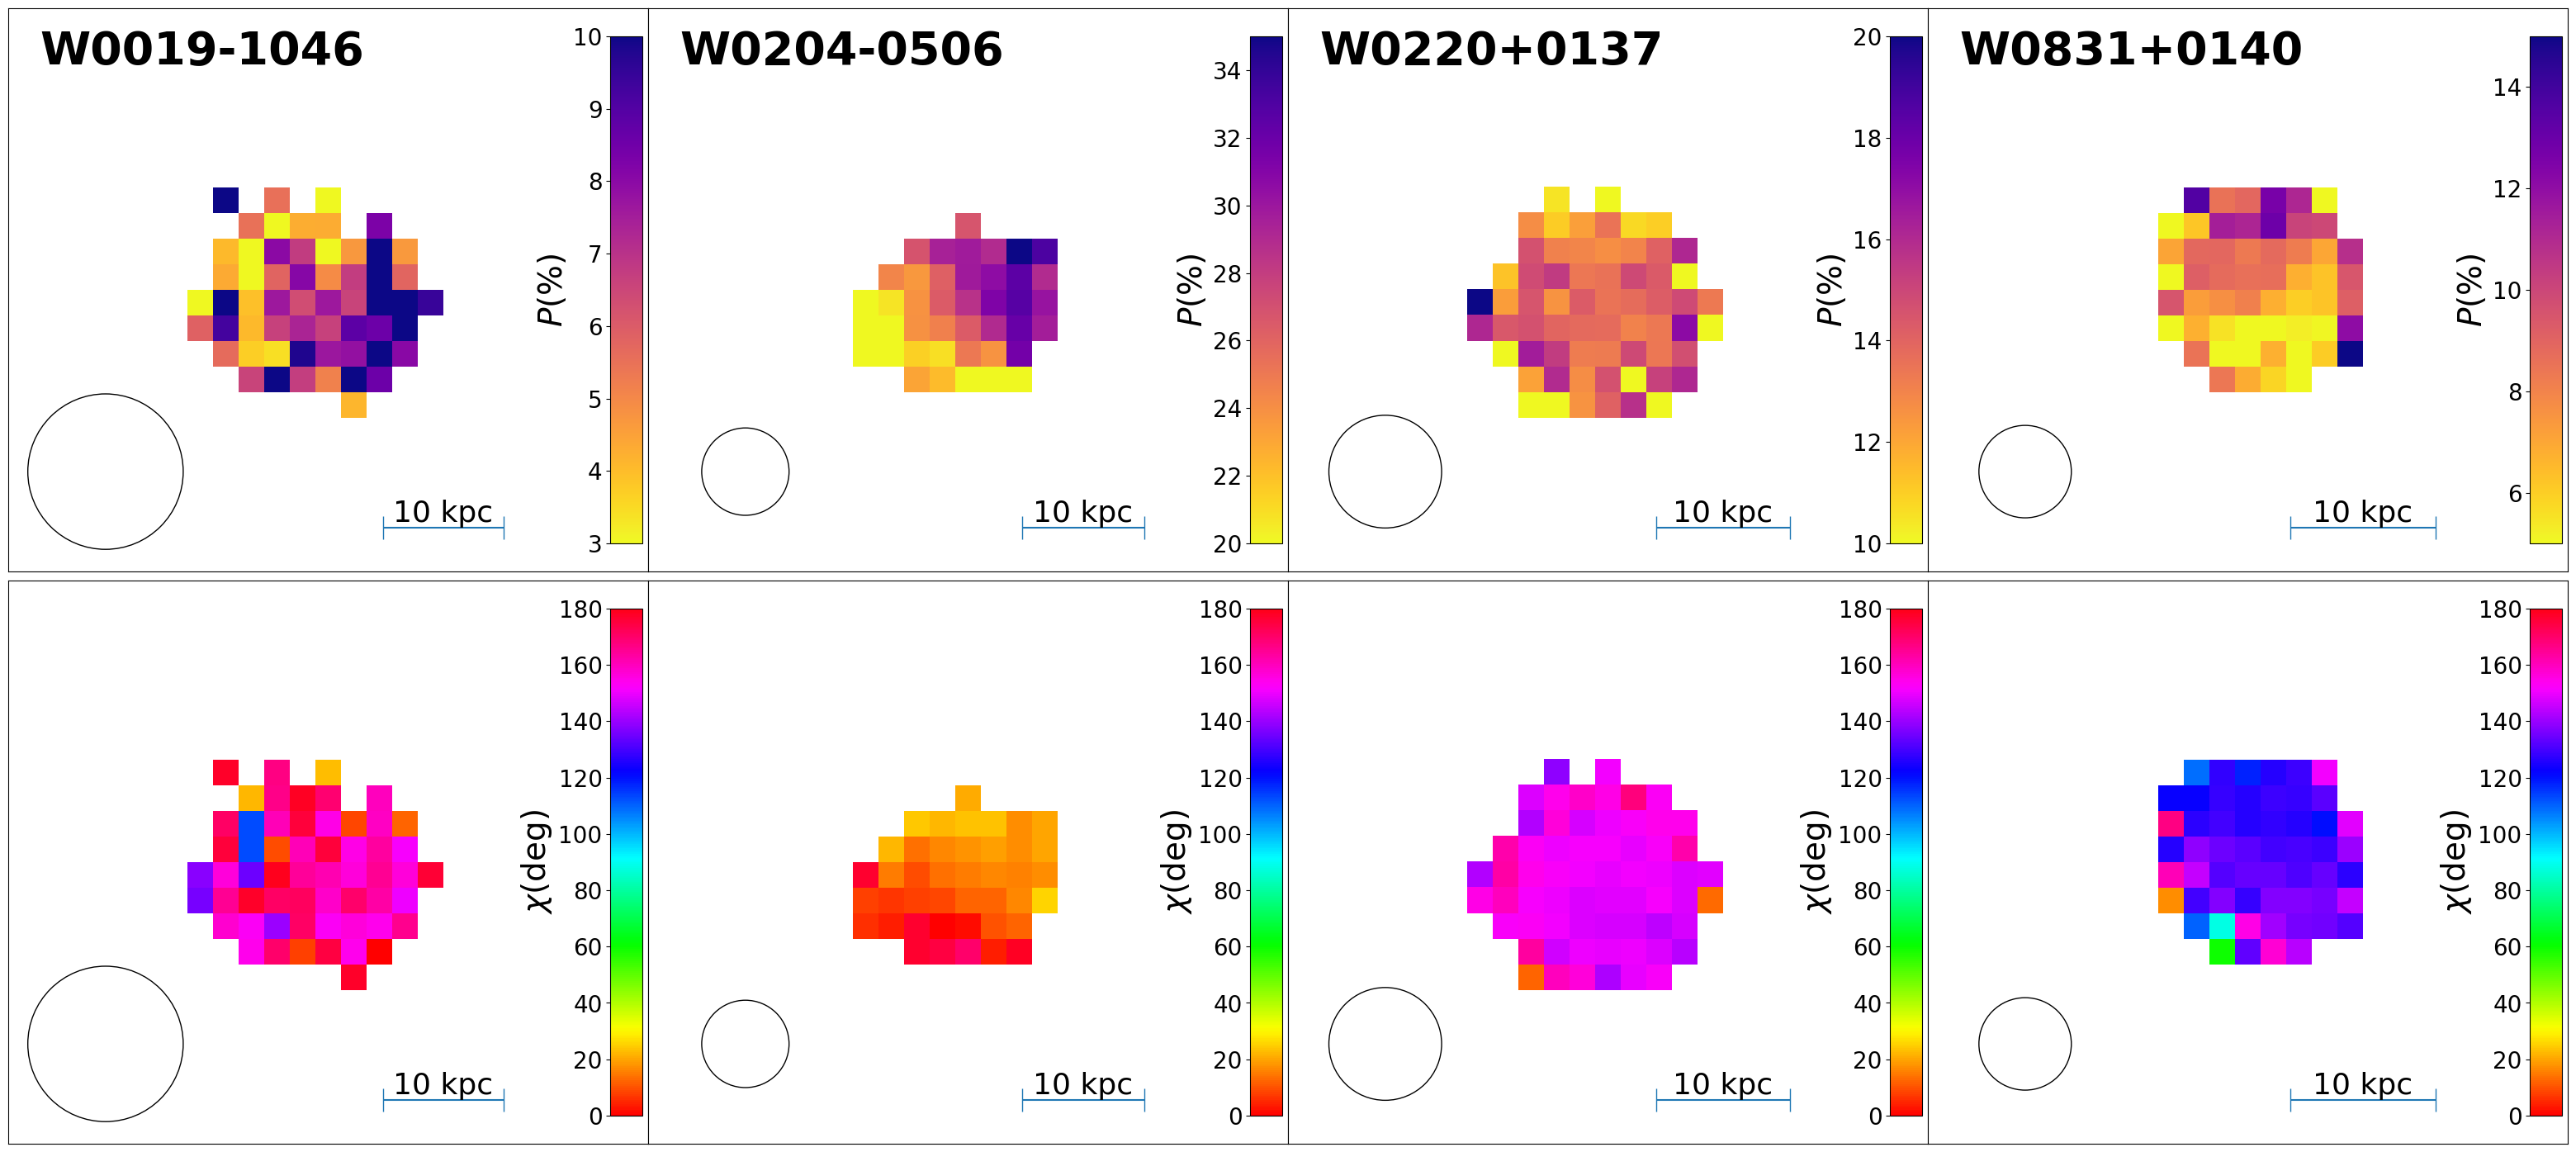

In [8]:
make_plot(size=22, output_fname="Original_Resolution_2D_pol.png")

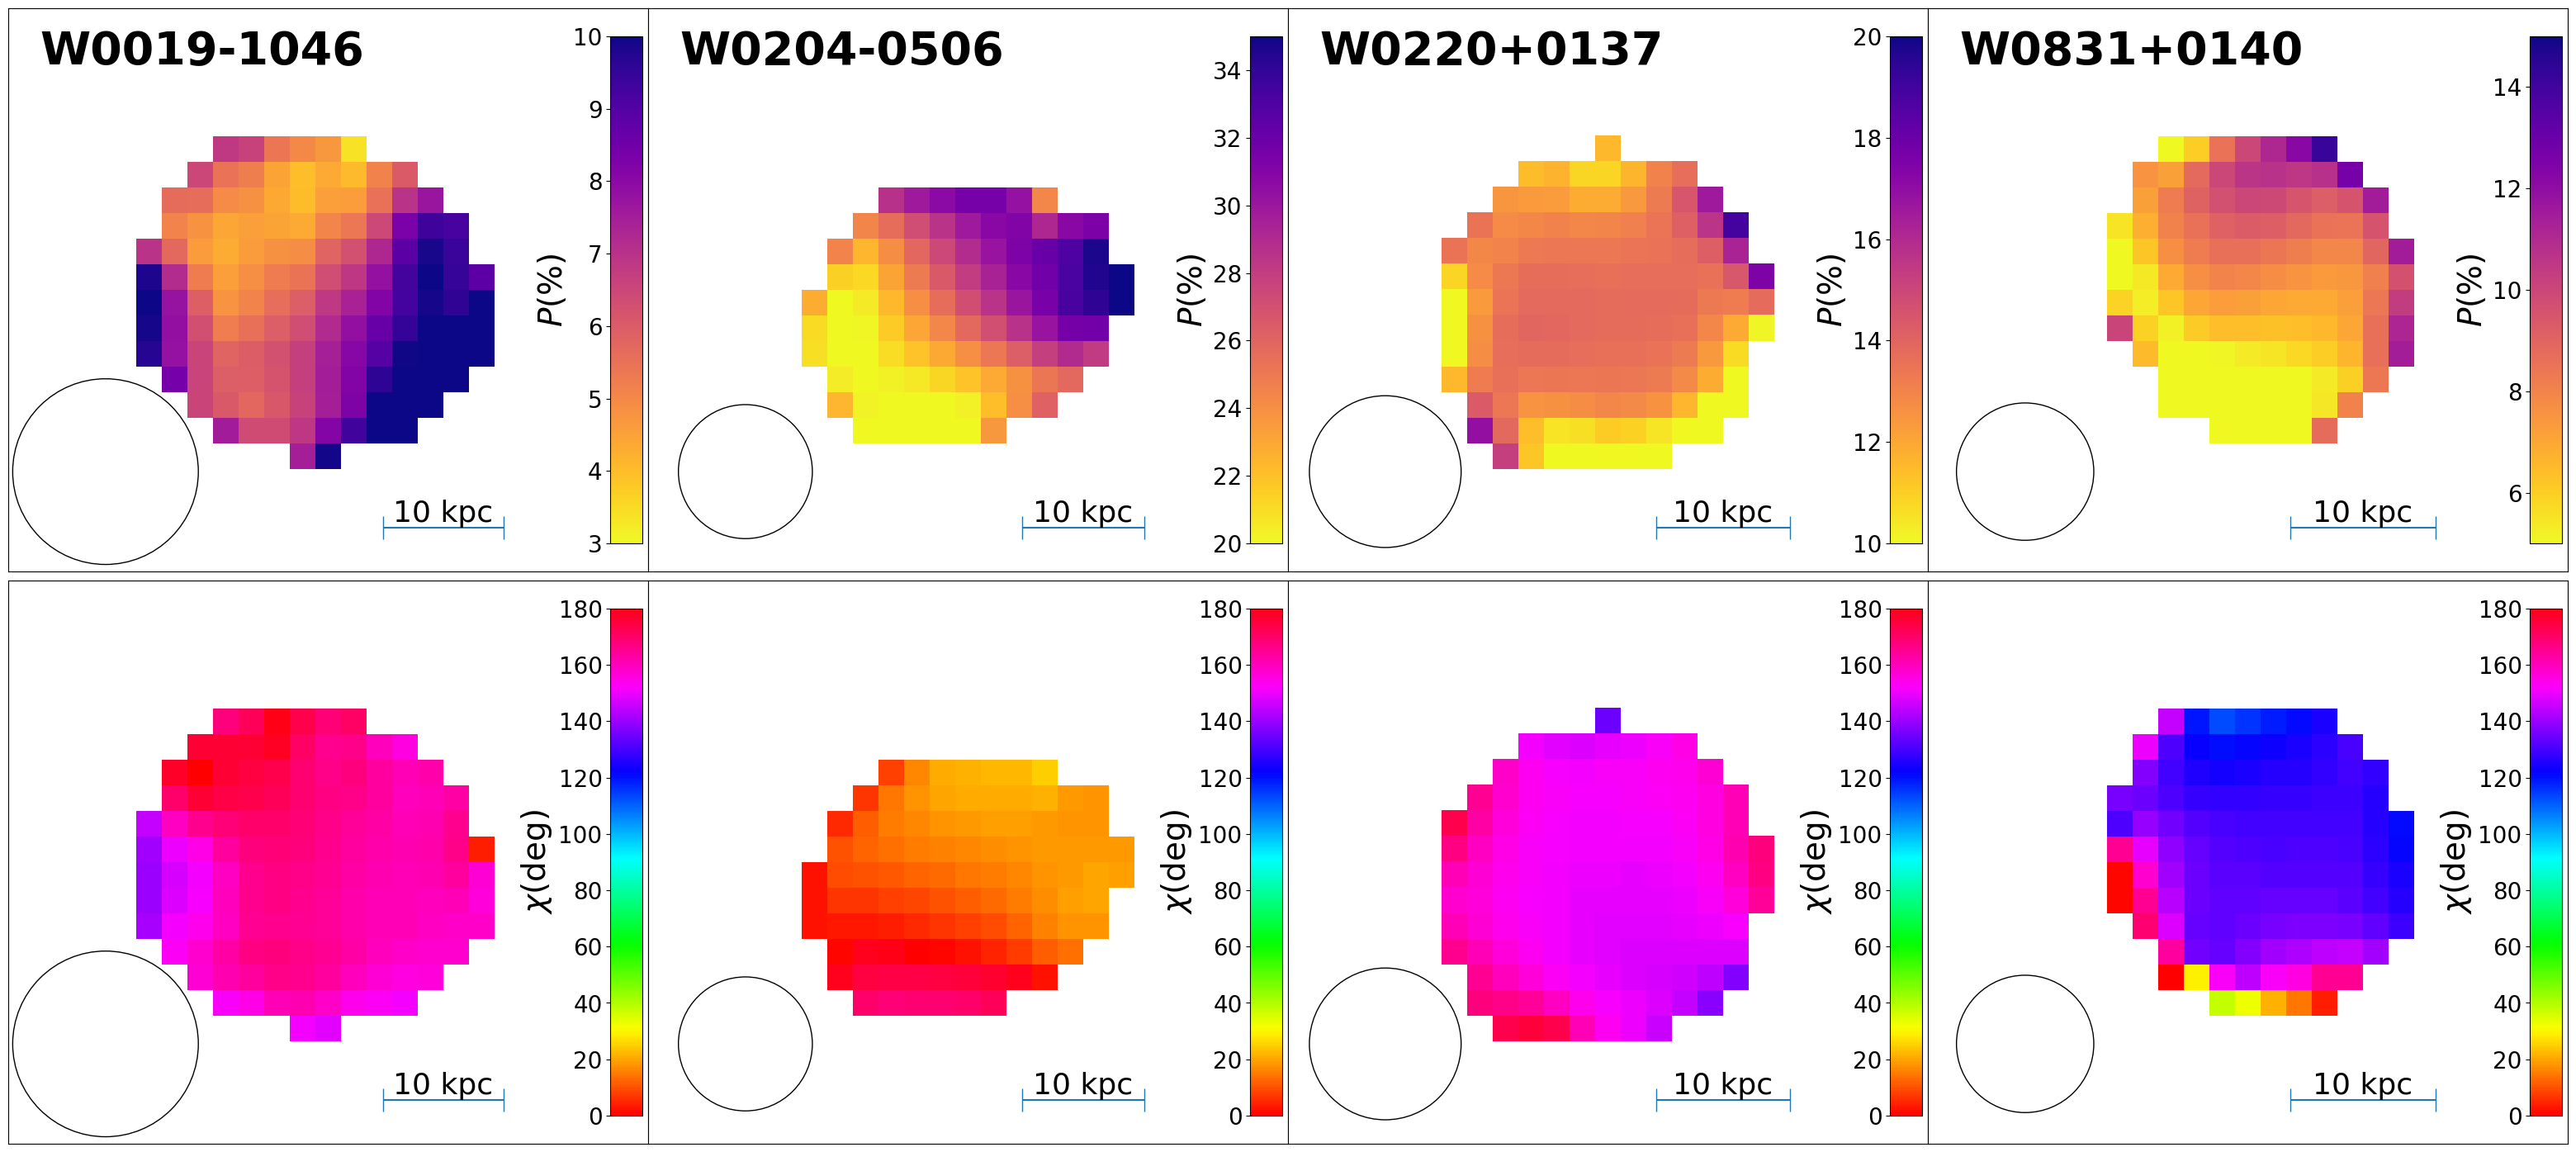

In [9]:
make_plot(blurr_PSF_FWHM=1.0, size=22, output_fname="Blurred_1.0_Resolution_2D_pol.png")

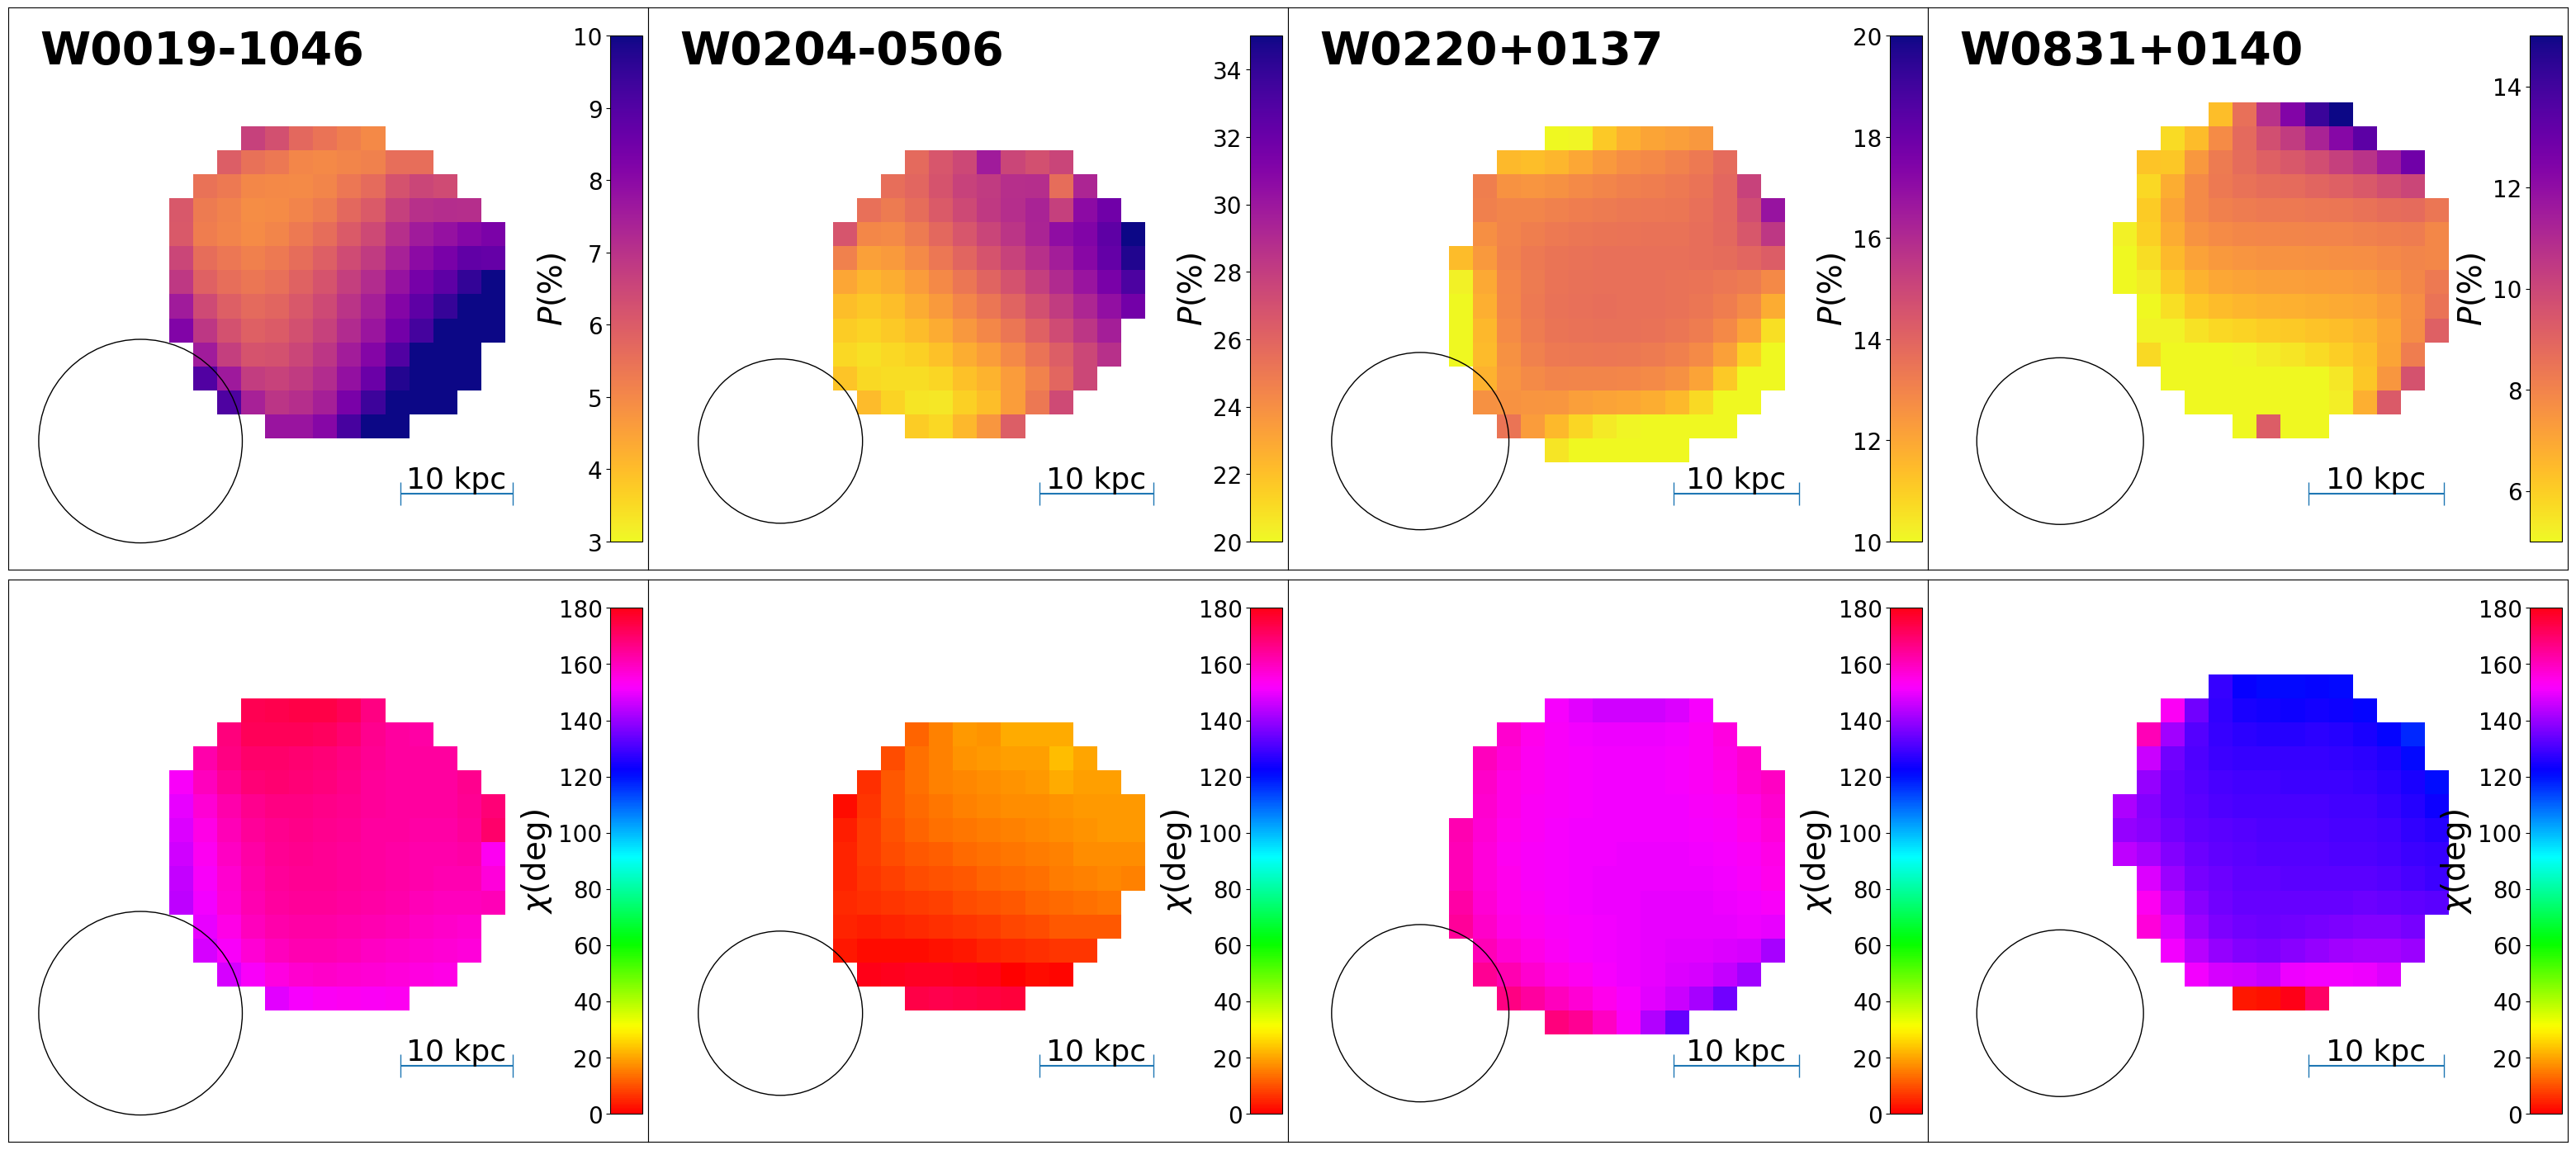

In [10]:
make_plot(blurr_PSF_FWHM=1.5, size=22, output_fname="Blurred_1.5_Resolution_2D_pol.png")